## First of All

In [1]:
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy import ndimage
from google.colab import files

## All OOPs

In [2]:
class DataLoader:
    def __init__(self, url, extract_path):
        self.url = url
        self.extract_path = extract_path

    def download_and_extract_zip(self):
        """Download and extract the zip file from the provided URL."""
        zip_path = 'arabic_handwritten_characters.zip'
        response = requests.get(self.url)
        with open(zip_path, 'wb') as file:
            file.write(response.content)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(self.extract_path)

    def load_data(self):
        """Load and preprocess the dataset."""
        self.download_and_extract_zip()

        train_images = pd.read_csv(f'{self.extract_path}/csvTrainImages 13440x1024.csv', header=None).values
        train_labels = pd.read_csv(f'{self.extract_path}/csvTrainLabel 13440x1.csv', header=None).values.flatten()
        test_images = pd.read_csv(f'{self.extract_path}/csvTestImages 3360x1024.csv', header=None).values
        test_labels = pd.read_csv(f'{self.extract_path}/csvTestLabel 3360x1.csv', header=None).values.flatten()

        # Normalize the images
        train_images = train_images / 255.0
        test_images = test_images / 255.0

        # Find the number of classes from the labels
        num_classes = max(train_labels.max(), test_labels.max()) + 1

        # Convert labels to categorical
        train_labels = to_categorical(train_labels, num_classes=num_classes)
        test_labels = to_categorical(test_labels, num_classes=num_classes)

        return (train_images, train_labels), (test_images, test_labels)

    def invert_colors(self, images):
        """Invert the colors of the images."""
        return 1 - images

    def augment_data(self, images, labels):
        """Augment the dataset by adding inverted images."""
        inverted_images = self.invert_colors(images)
        augmented_images = np.vstack((images, inverted_images))
        augmented_labels = np.vstack((labels, labels))
        return augmented_images, augmented_labels

    def show_samples(self, images, labels, num_samples=5, inverted=False):
        """Display a few samples from the dataset."""

        rows = (num_samples + 7) // 8
        cols = min(num_samples, 8)
        # else:
        #     rows = (num_samples + 1) // 2
        #     cols = min(num_samples, 2)

        plt.figure(figsize=(cols * 4, rows * 4))
        for i in range(num_samples):
            ax = plt.subplot(rows, cols, i + 1)
            img = images[i].reshape(32, 32)
            img = ndimage.rotate(img, -90)
            img = np.fliplr(img)
            plt.imshow(img, cmap='gray')
            label = np.argmax(labels[i])
            plt.title(f'Inverted {label}' if inverted else f'Original {label}')
            plt.axis('off')
        plt.show()

class ModelHandler:
    def __init__(self):
        self.model = None

    def build_model(self, num_classes):
        """Build and compile the neural network model."""
        self.model = Sequential([
            Dense(1024, activation='relu', input_shape=(1024,), kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, train_data, test_data, epochs, batch_size=128):
        """Train the model with the given training data."""
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001)

        history = self.model.fit(
            train_data[0], train_data[1],
            epochs=epochs,
            batch_size=batch_size,
            validation_data=test_data,
            callbacks=[early_stopping, model_checkpoint, reduce_lr]
        )
        return history

    def save_model(self, file_path):
        """Save the trained model to a file."""
        self.model.save(file_path)

    def load_model(self, file_path):
        """Load a trained model from a file."""
        self.model = load_model(file_path)
        return self.model

    def plot_metrics(self, history):
        """Plot the training accuracy, validation accuracy, training loss, and validation loss."""
        history_df = pd.DataFrame(history.history)

        plt.figure(figsize=(12, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history_df['accuracy'], label='Training Accuracy')
        plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy')

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history_df['loss'], label='Training Loss')
        plt.plot(history_df['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')

        plt.tight_layout()
        plt.show()

class ArabicLabelHandler:
    def __init__(self):
        self.labels = {
            1: "Alef (أ)",
            2: "Bah (ب)",
            3: "Teh (ت)",
            4: "Theh (ث)",
            5: "Jeem (ج)",
            6: "Hah (ح)",
            7: "Khah (خ)",
            8: "Dal (د)",
            9: "Thal (ذ)",
            10: "Reh (ر)",
            11: "Zay (ز)",
            12: "Seen (س)",
            13: "Sheen (ش)",
            14: "Sad (ص)",
            15: "Dad (ض)",
            16: "Tah (ط)",
            17: "Zah (ظ)",
            18: "Ain (ع)",
            19: "Ghain (غ)",
            20: "Feh (ف)",
            21: "Qaf (ق)",
            22: "Kaf (ك)",
            23: "Lam (ل)",
            24: "Meem (م)",
            25: "Noon (ن)",
            26: "Heh (هـ)",
            27: "Waw (و)",
            28: "Yeh (ي)"
        }

    def get_label(self, class_number):
        return self.labels.get(class_number, "Unknown")

    def get_num_classes(self):
        return len(self.labels)

class ImagePredictor:
    def __init__(self, model, label_handler):
        self.model = model
        self.label_handler = label_handler

    def predict_character(self, image_path):
        """Predict the Arabic character from a given image."""
        # Load and preprocess the image
        img = load_img(image_path, color_mode='grayscale', target_size=(32, 32))
        img = ndimage.rotate(img, -90)  # Rotate the image by -90 degrees to fix orientation
        img = np.fliplr(img)  # Flip the image horizontally to correct left-right orientation
        img_array = img_to_array(img).reshape((1, 1024))
        img_array = img_array / 255.0

        # Predict the class
        prediction = self.model.predict(img_array)
        predicted_class = np.argmax(prediction)
        predicted_label = self.label_handler.get_label(predicted_class)
        return predicted_class, predicted_label

    def display_image(self, image_path):
        """Display the image using matplotlib."""
        img = load_img(image_path, color_mode='grayscale', target_size=(32, 32))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

## Load Data

In [3]:
dataset_url = 'https://github.com/mloey/Arabic-Handwritten-Characters-Dataset/raw/master/Arabic%20Handwritten%20Characters%20Dataset%20CSV.zip'
extract_path = './data'

In [4]:
data_loader = DataLoader(dataset_url, extract_path)

## Train and Test also augmented

In [5]:
(train_images, train_labels), (test_images, test_labels) = data_loader.load_data()

train_images_augmented, train_labels_augmented = data_loader.augment_data(train_images, train_labels)
test_images_augmented, test_labels_augmented = data_loader.augment_data(test_images, test_labels)

### Show Train Image

Original Train Images:


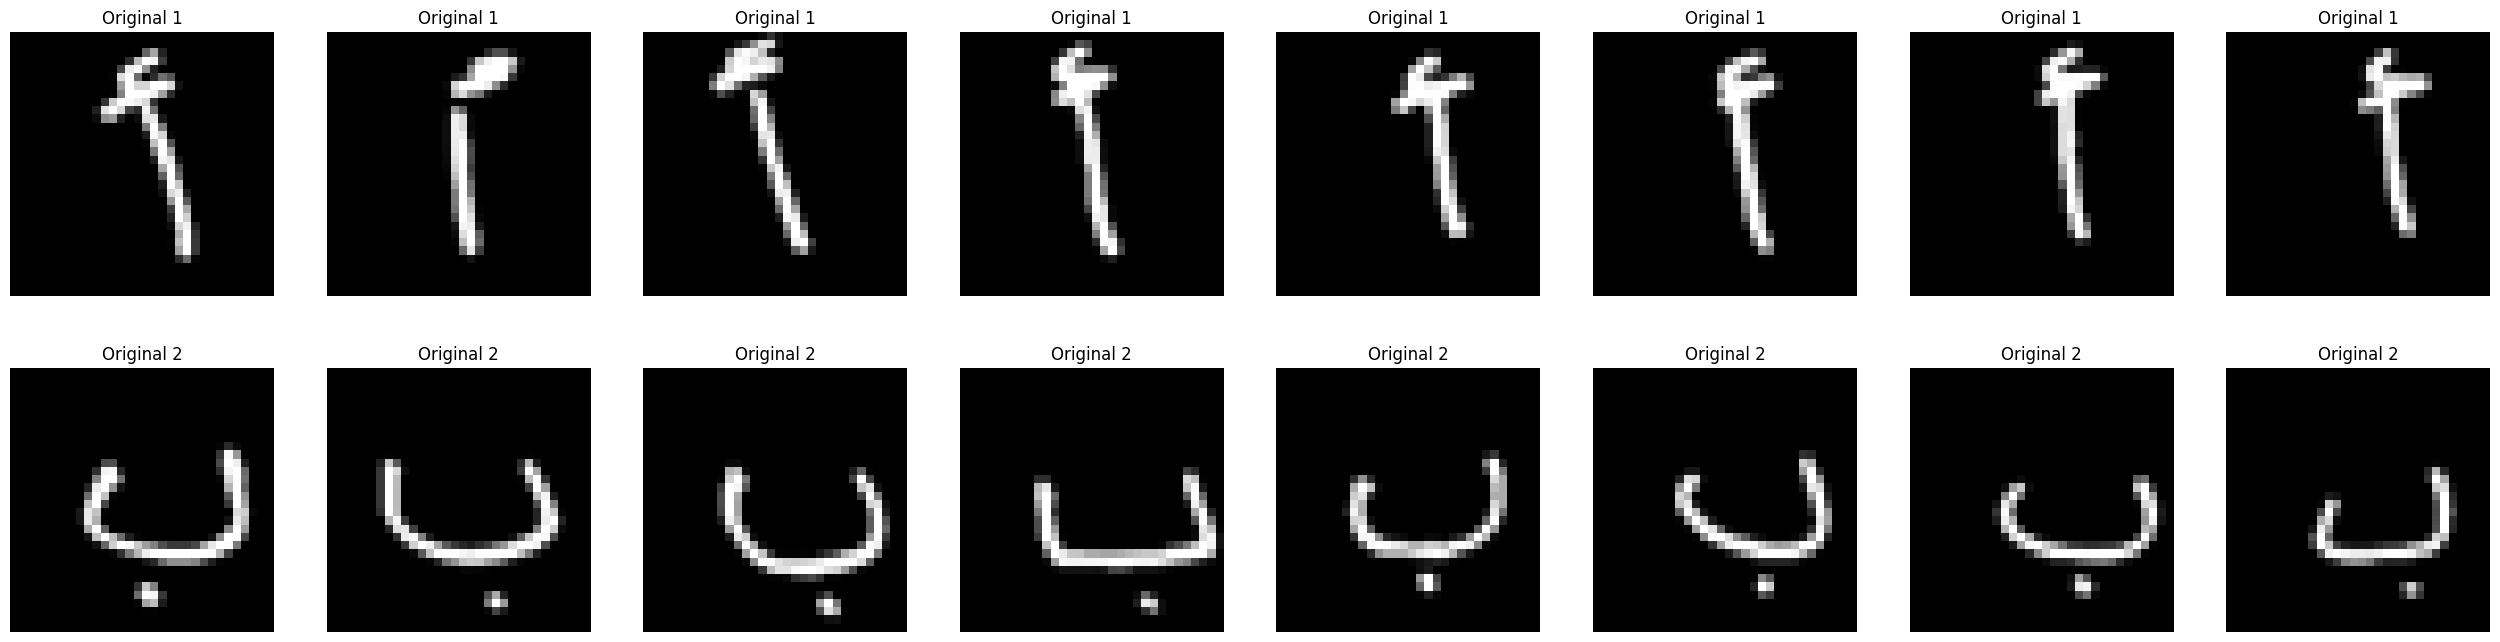

Inverted Train Images:


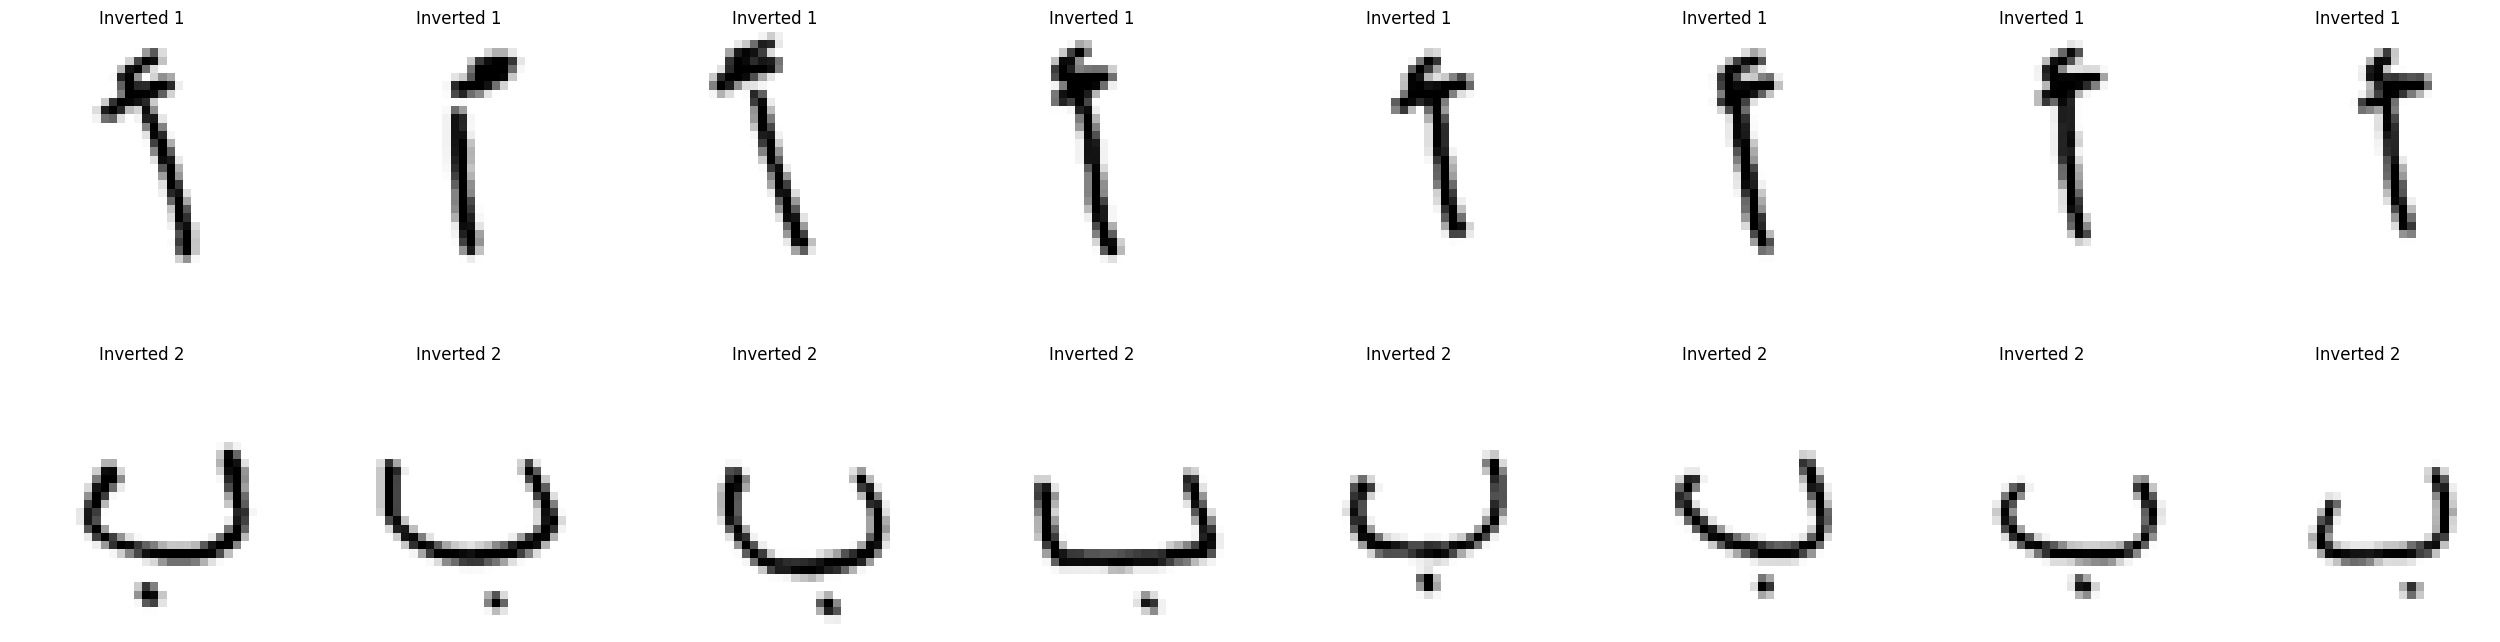

In [6]:
print("Original Train Images:")
data_loader.show_samples(images=train_images, labels=train_labels, num_samples=16)

print("Inverted Train Images:")
data_loader.show_samples(images=train_images_augmented[len(train_images):], labels=train_labels_augmented, num_samples=16, inverted=True)

### Show Test Image

Original Test Images:


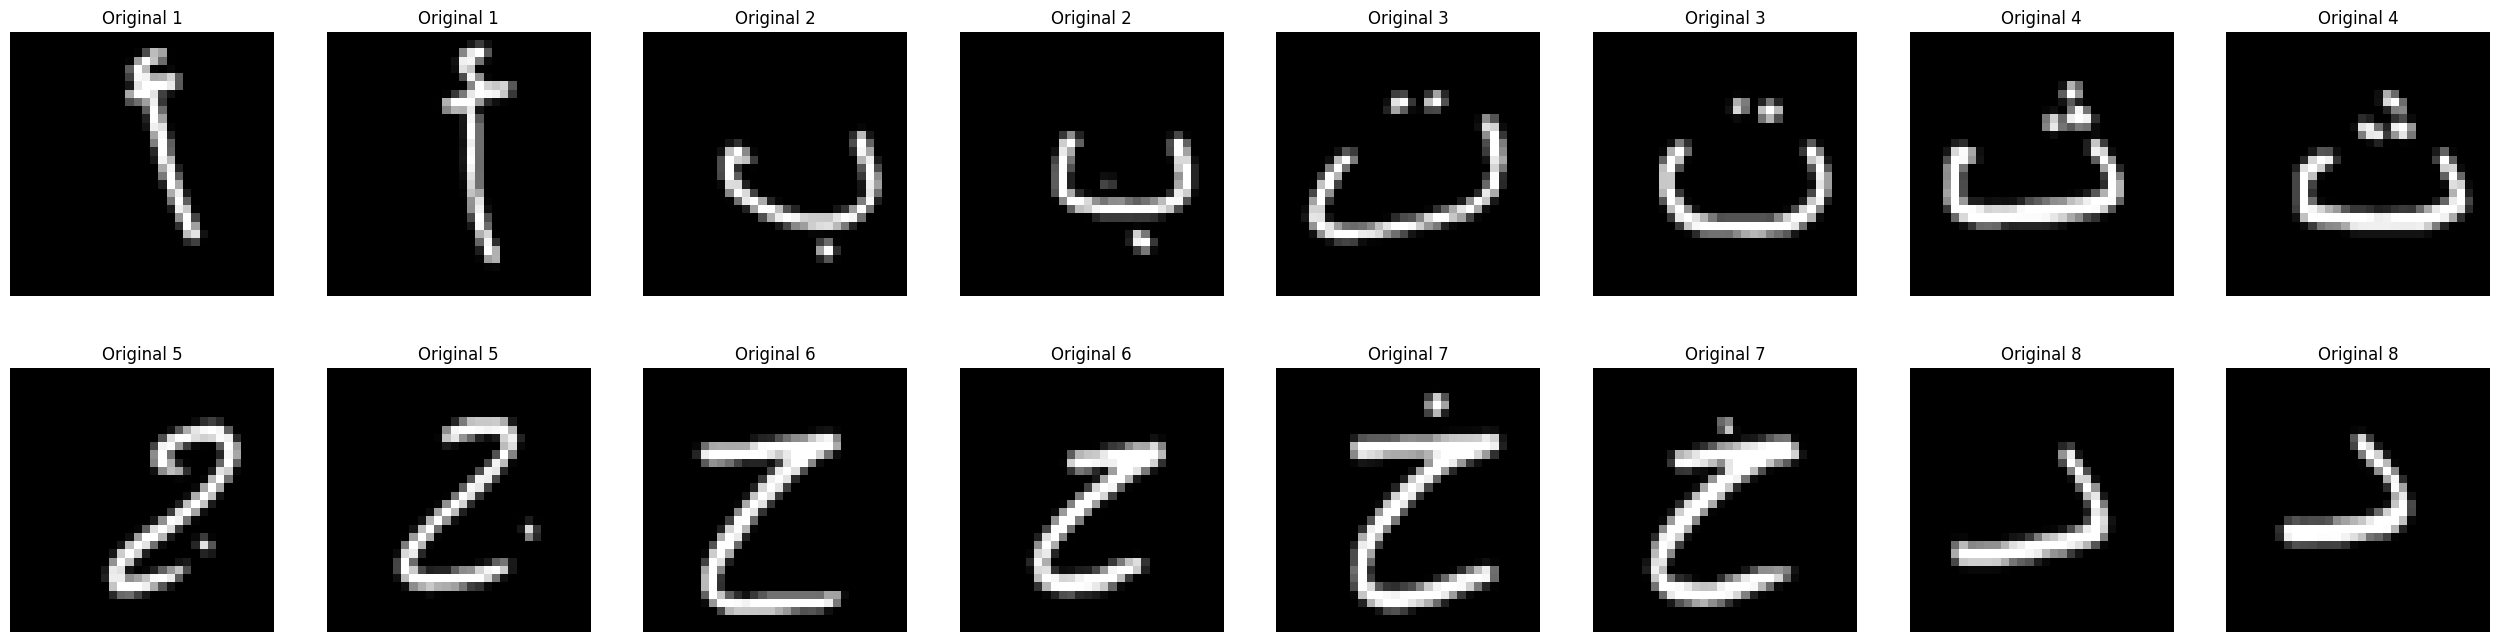

Inverted Test Images:


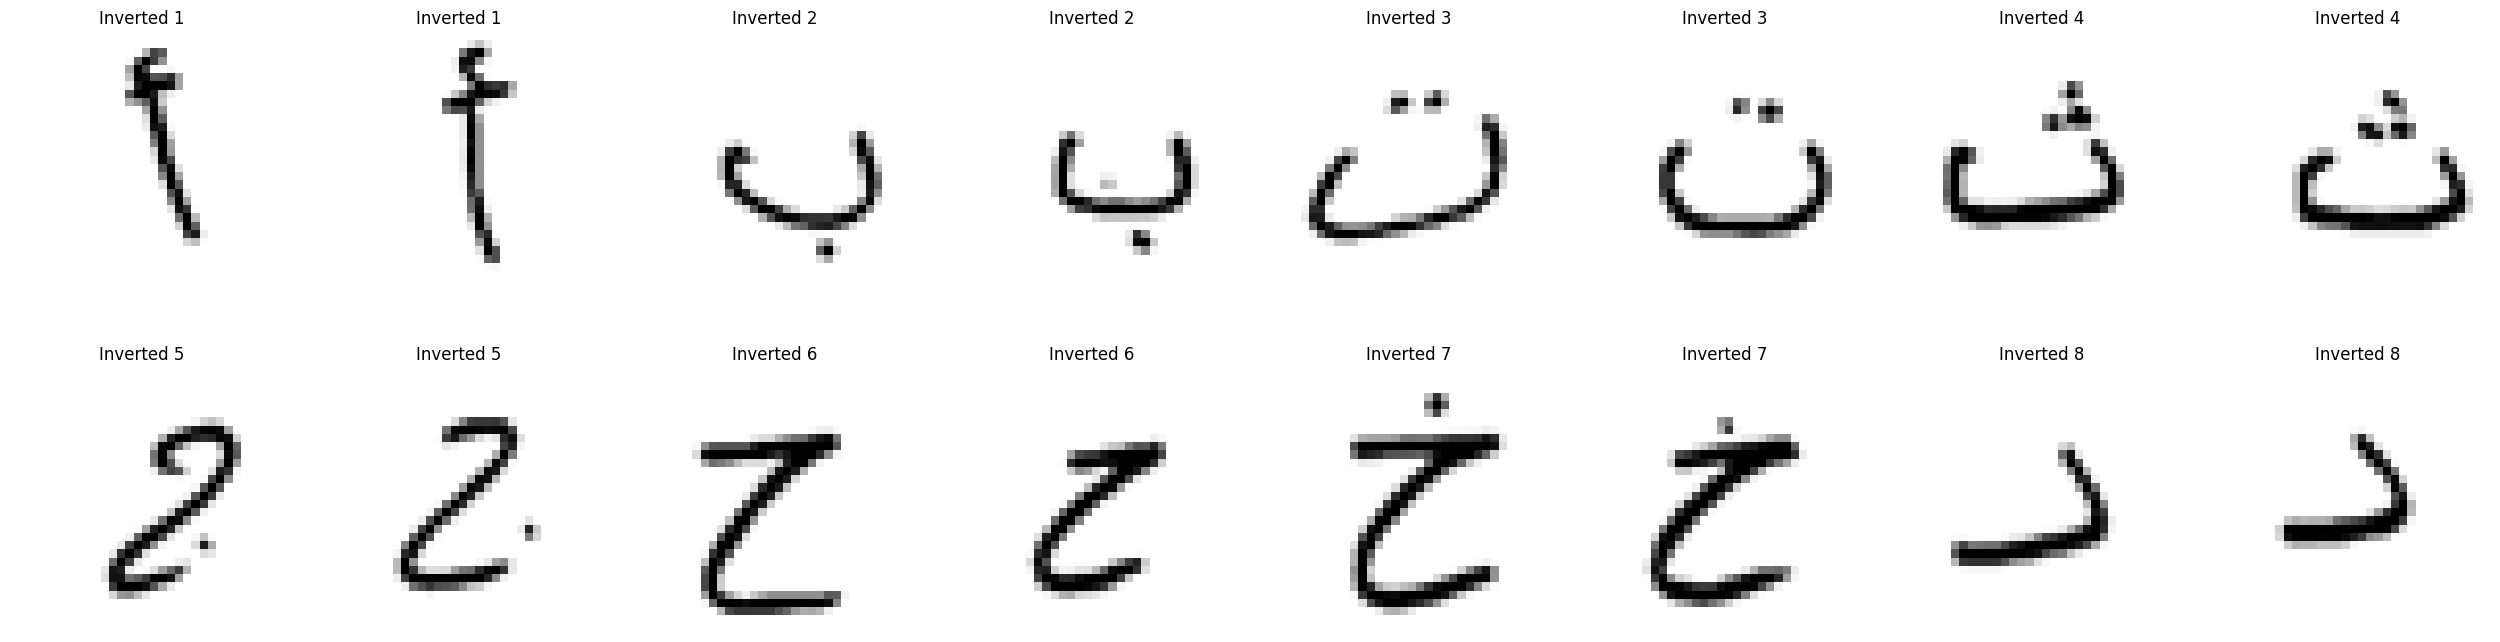

In [7]:
print("Original Test Images:")
data_loader.show_samples(images=test_images, labels=test_labels, num_samples=16)

print("Inverted Test Images:")
data_loader.show_samples(images=test_images_augmented[len(test_images):], labels=test_labels_augmented, num_samples=16, inverted=True)

## Model Handler

In [8]:
model_handler = ModelHandler()
label_handler = ArabicLabelHandler()
num_classes = train_labels.shape[1]

### Model Architecture

In [9]:
model_handler.build_model(num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

### Train Model

In [10]:
history = model_handler.train_model((train_images_augmented, train_labels_augmented), (test_images, test_labels), 1000, 128)

Epoch 1/1000
210/210 [==============================] - 8s 7ms/step - loss: 4.8449 - accuracy: 0.1641 - val_loss: 4.5420 - val_accuracy: 0.1521 - lr: 0.0010
Epoch 2/1000
 25/210 [==>...........................] - ETA: 0s - loss: 3.9241 - accuracy: 0.2606

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 1s 5ms/step - loss: 3.6419 - accuracy: 0.3054 - val_loss: 3.4473 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/1000
210/210 [==============================] - 1s 5ms/step - loss: 3.1041 - accuracy: 0.3734 - val_loss: 2.3471 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 4/1000
210/210 [==============================] - 1s 5ms/step - loss: 2.7818 - accuracy: 0.4092 - val_loss: 2.0162 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 5/1000
210/210 [==============================] - 1s 5ms/step - loss: 2.5519 - accuracy: 0.4352 - val_loss: 1.7022 - val_accuracy: 0.6634 - lr: 0.0010
Epoch 6/1000
210/210 [==============================] - 1s 6ms/step - loss: 2.4090 - accuracy: 0.4521 - val_loss: 1.5557 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 7/1000
210/210 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.4636 - val_loss: 1.5581 - val_accuracy: 0.6747 - lr: 0.0010
Epoch 8/1000
210/210 [==============================] - 1s 6ms/step - l

### Model Plot

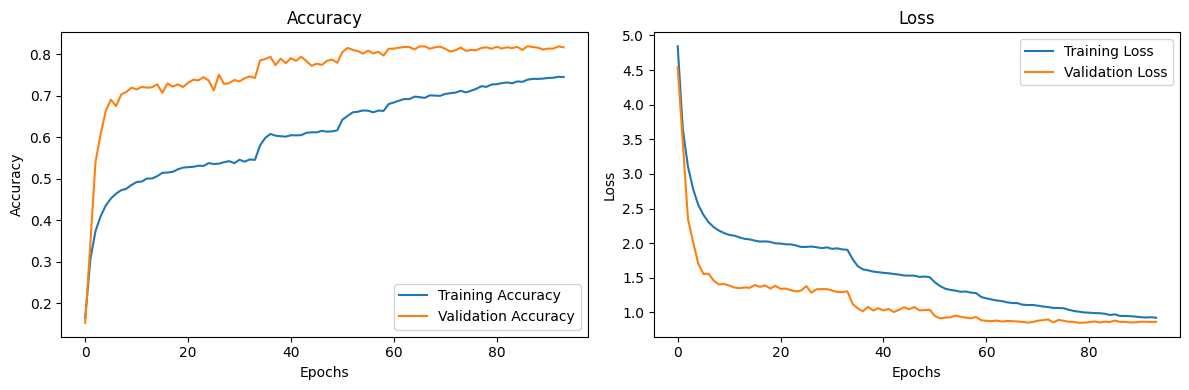

In [11]:
model_handler.plot_metrics(history)

### Save and Load Model

In [12]:
model_handler.save_model('zeronine_ar_char.h5')

In [13]:
model_handler.load_model('zeronine_ar_char.h5')

In [14]:
print(type(model_handler.model))

<class 'keras.src.engine.sequential.Sequential'>


## Predict

In [15]:
image_predictor = ImagePredictor(model_handler.model, label_handler)

### Black Background

Saving Screenshot 2024-07-29 084848.png to Screenshot 2024-07-29 084848.png
1/1 [==============================] - 0s 224ms/step
Predicted Class: 28
Predicted Label: Yeh (ي)


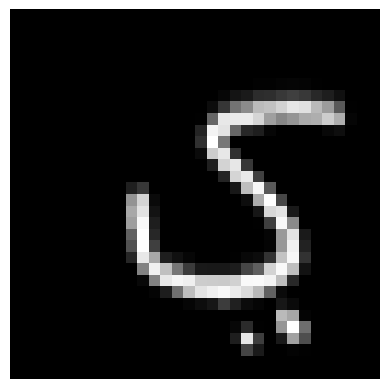

In [16]:
uploaded = files.upload()
for fn in uploaded.keys():
    predicted_class, predicted_label = image_predictor.predict_character(fn)
    print(f"Predicted Class: {predicted_class}\nPredicted Label: {predicted_label}")
    image_predictor.display_image(fn)

### White Background

Saving Screenshot 2024-07-29 152500.png to Screenshot 2024-07-29 152500.png
1/1 [==============================] - 0s 17ms/step
Predicted Class: 28
Predicted Label: Yeh (ي)


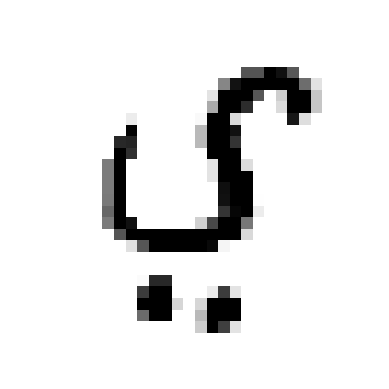

In [17]:
uploaded = files.upload()
for fn in uploaded.keys():
    predicted_class, predicted_label = image_predictor.predict_character(fn)
    print(f"Predicted Class: {predicted_class}\nPredicted Label: {predicted_label}")
    image_predictor.display_image(fn)